In [2]:
import duckdb
import pyarrow.parquet as pq
import pandas as pd

In [3]:
reviews = "../reviews.parquet"

pRev = pq.ParquetFile(reviews)
revSchema = pRev.schema_arrow
print(revSchema)


recommendationid: int64
appid: int64
author_steamid: int64
author_playtime_at_review: int64
author_last_played: int64
language: string
timestamp_created: timestamp[ns]
votes_up: int64
votes_funny: int64
weighted_vote_score: double
comment_count: int64
steam_purchase: int64
received_for_free: int64
written_during_early_access: int64
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 1876


In [4]:
games = "../games.parquet"
pGames = pq.ParquetFile(games)
gamesSchema = pGames.schema_arrow
print(gamesSchema)

appid: int64
game: string
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 290


In [5]:
con = duckdb.connect()


query = f"""
    SELECT *
    FROM '{reviews}' AS r
    JOIN '{games}' AS g
    ON r.appid = g.appid
    LIMIT 10
"""

first10= con.execute(query).fetchdf()

print(first10)


   recommendationid   appid     author_steamid  author_playtime_at_review  \
0          61858151  105450  76561198095427016                         74   
1          61858130  105450  76561198367517870                       5972   
2          61857258  105450  76561198202501564                      15604   
3          61855517  105450  76561199014804619                        783   
4          61855022  105450  76561198147562649                         42   
5          61854906  105450  76561198274390926                      67134   
6          61851893  105450  76561198858100402                       1829   
7          61848535  105450  76561198818482403                      11231   
8          61844535  105450  76561198008998762                       1604   
9          61838163  105450  76561198207761347                        307   

   author_last_played    language   timestamp_created  votes_up  votes_funny  \
0          1590676756     english 2020-01-14 20:39:20         0         

In [6]:
countr = f"""
    SELECT COUNT(distinct appid) AS total_reviews
    FROM '{reviews}'
"""
df_reviews_count = con.execute(countr).fetchdf()
print(df_reviews_count["total_reviews"][0])

103167


In [7]:
countg = f"""
    SELECT COUNT(*) AS unique_games
    FROM '{games}'
"""
game_apid = con.execute(countg).fetchdf()
print(game_apid["unique_games"][0])

105893


In [8]:
countg = f"""
    SELECT COUNT(DISTINCT game) AS unique_games
    FROM '{games}'
"""
games_count = con.execute(countg).fetchdf()
print(games_count["unique_games"][0])

105206


In [9]:
dupes = f"""
    SELECT
        game,
        COUNT(DISTINCT appid) AS distinct_appids
    FROM '{games}'
    GROUP BY game
    HAVING COUNT(DISTINCT appid) > 1
    ORDER BY distinct_appids DESC
    LIMIT 10;
"""
qdupes = con.execute(dupes).fetchdf()
print(qdupes)

             game  distinct_appids
0            None               68
1          Escape                6
2          Aurora                6
3           Alone                6
4        Parasite                4
5         Requiem                4
6            Lost                4
7      Soundtrack                4
8   Hide and Seek                4
9  Space Survival                4


In [10]:
parq = "rev.parquet"

In [11]:
revp = pq.ParquetFile(parq).schema_arrow
print(revp)

recommendationid: int64
game: string
author_steamid: int64
author_playtime_at_review: int64
author_last_played: int64
language: string
timestamp_created: timestamp[ns]
votes_up: int64
votes_funny: int64
weighted_vote_score: double
comment_count: int64
steam_purchase: int64
received_for_free: int64
written_during_early_access: int64
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 1877


In [12]:
pquery = f"""
    SELECT *
    FROM '{parq}'
    LIMIT 10
"""

f10=con.execute(pquery).fetchdf()

print(f10)

   recommendationid            game     author_steamid  \
0         148919893  Counter-Strike  76561199036724879   
1         148919350  Counter-Strike  76561198826729322   
2         148913051  Counter-Strike  76561199101237625   
3         148912714  Counter-Strike  76561198347582422   
4         148912575  Counter-Strike  76561198363716821   
5         148906148  Counter-Strike  76561198198293481   
6         148905699  Counter-Strike  76561198820122182   
7         148900627  Counter-Strike  76561198346217916   
8         148899121  Counter-Strike  76561199143791757   
9         148898785  Counter-Strike  76561198853145449   

   author_playtime_at_review  author_last_played  language  \
0                        197          1698336369   russian   
1                        441          1698335809   russian   
2                       1313          1698338635   turkish   
3                       1612          1698341834   russian   
4                        197          1698329401   

In [13]:
ugames = f"""
    SELECT COUNT(DISTINCT game) AS unique_games
    FROM '{parq}'
"""
unique_games = con.execute(ugames).fetchdf()
print(unique_games["unique_games"][0])

102513


In [14]:


query = f"""
    SELECT COUNT(*) FILTER (WHERE game IS NULL) AS missing_game,
    COUNT(*) FILTER (WHERE game = '') AS empty_game
    FROM '{parq}'
"""

res = con.execute(query).fetchdf()
print(res)


   missing_game  empty_game
0          5266           0


In [15]:


query = f"""
    SELECT *
    FROM '{parq}'
    WHERE game IS NULL
    LIMIT 10
"""

res = con.execute(query).fetchdf()
print(res)


   recommendationid  game     author_steamid  author_playtime_at_review  \
0          84555529  None  76561197971905574                        103   
1          66663227  None  76561198047671566                         72   
2          64124201  None  76561197970265034                        121   
3          56306807  None  76561197994407206                         68   
4          55664796  None  76561197974522156                         23   
5          53814851  None  76561198338012436                        171   
6          51837192  None  76561198149884953                         80   
7          51522225  None  76561198031466665                        259   
8          51019577  None  76561198122973075                        300   
9          50907952  None  76561198966624917                        122   

   author_last_played language   timestamp_created  votes_up  votes_funny  \
0          1610462658  english 2021-01-12 15:04:47         1            0   
1          158604023

In [16]:
out = "noNull.parquet"

con = duckdb.connect()

con.execute(f"CREATE TABLE reviews AS SELECT * FROM '{parq}'")

con.execute("""
    CREATE TABLE noNull AS
    SELECT *
    FROM reviews
    WHERE game IS NOT NULL
""")

con.execute(f"COPY noNull TO '{out}' (FORMAT PARQUET)")

row_count = con.execute("SELECT COUNT(*) FROM noNull").fetchone()[0]
print(f"Rows after removing NULL games: {row_count}")
print(f"Saved cleaned data to: {out}")

Rows after removing NULL games: 111378451
Saved cleaned data to: noNull.parquet


In [74]:


pRev = pq.ParquetFile(out)
revSchema = pRev.schema_arrow
print(revSchema)


recommendationid: int64
game: string
author_steamid: int64
author_playtime_at_review: int64
author_last_played: int64
language: string
timestamp_created: timestamp[ns]
votes_up: int64
votes_funny: int64
weighted_vote_score: double
comment_count: int64
steam_purchase: int64
received_for_free: int64
written_during_early_access: int64


In [17]:
query = f"""
    SELECT COUNT(*) FILTER (WHERE game IS NULL) AS missing_game,
    COUNT(*) FILTER (WHERE game = '') AS empty_game
    FROM '{out}'
"""

res = con.execute(query).fetchdf()
print(res)


   missing_game  empty_game
0             0           0


In [18]:
query_contradictory = f"""
SELECT COUNT(*) AS contradictory_rows
FROM '{out}'
WHERE steam_purchase = TRUE
  AND received_for_free = TRUE;
"""

contradict_df = con.execute(query_contradictory).fetchdf()
print("Contradictory Purchase Info (steam_purchase=TRUE & received_for_free=TRUE):")
print(contradict_df)

Contradictory Purchase Info (steam_purchase=TRUE & received_for_free=TRUE):
   contradictory_rows
0             1326705


In [19]:
query_purchase_dist = f"""
SELECT
  steam_purchase,
  COUNT(*) AS count_reviews
FROM '{out}'
GROUP BY steam_purchase;
"""

purchase_dist_df = con.execute(query_purchase_dist).fetchdf()
print("Distribution of steam_purchase:")
print(purchase_dist_df)

Distribution of steam_purchase:
   steam_purchase  count_reviews
0               0       37719573
1               1       73658878


In [20]:
query_early_access_dist = f"""
SELECT
  written_during_early_access,
  COUNT(*) AS count_reviews
FROM '{out}'
GROUP BY written_during_early_access;
"""

early_access_dist_df = con.execute(query_early_access_dist).fetchdf()
print("Distribution of written_during_early_access:")
print(early_access_dist_df, "\n")

Distribution of written_during_early_access:
   written_during_early_access  count_reviews
0                            0       99290667
1                            1       12087784 



In [21]:
query_helpfulness_purchase = f"""
SELECT
  steam_purchase,
  AVG(votes_up) AS avg_votes_up,
  AVG(weighted_vote_score) AS avg_weighted_score
FROM '{out}'
GROUP BY steam_purchase;
"""

helpfulness_purchase_df = con.execute(query_helpfulness_purchase).fetchdf()
print("Average helpfulness by steam_purchase:")
print(helpfulness_purchase_df)

Average helpfulness by steam_purchase:
   steam_purchase  avg_votes_up  avg_weighted_score
0               0      2.204534            0.182216
1               1      2.338048            0.178149


In [22]:
query_helpfulness_early_access = f"""
SELECT
  written_during_early_access,
  AVG(votes_up) AS avg_votes_up,
  AVG(weighted_vote_score) AS avg_weighted_score
FROM '{out}'
GROUP BY written_during_early_access;
"""

helpfulness_early_access_df = con.execute(query_helpfulness_early_access).fetchdf()
print("Average helpfulness by early_access:")
print(helpfulness_early_access_df)

Average helpfulness by early_access:
   written_during_early_access  avg_votes_up  avg_weighted_score
0                            0      2.244189            0.177498
1                            1      2.692396            0.196185


In [24]:
q = f"""
SELECT * FROM '{out}' LIMIT 10;
"""



df = con.execute(q).fetchdf()
print(df)

   recommendationid            game     author_steamid  \
0         148919893  Counter-Strike  76561199036724879   
1         148919350  Counter-Strike  76561198826729322   
2         148913051  Counter-Strike  76561199101237625   
3         148912714  Counter-Strike  76561198347582422   
4         148912575  Counter-Strike  76561198363716821   
5         148906148  Counter-Strike  76561198198293481   
6         148905699  Counter-Strike  76561198820122182   
7         148900627  Counter-Strike  76561198346217916   
8         148899121  Counter-Strike  76561199143791757   
9         148898785  Counter-Strike  76561198853145449   

   author_playtime_at_review  author_last_played  language  \
0                        197          1698336369   russian   
1                        441          1698335809   russian   
2                       1313          1698338635   turkish   
3                       1612          1698341834   russian   
4                        197          1698329401   

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
def get_playtime_helpfulness(threshold=10):
    """
    Returns average helpful votes and total review counts,
    grouped by a playtime threshold (in hours).
    """
    query = f"""
    SELECT
        CASE
            WHEN author_playtime_at_review >= {threshold} THEN 1
            ELSE 0
        END AS long_playtime,
        AVG(votes_up) AS avg_helpful_votes,
        COUNT(*) AS total_reviews
    FROM {out}
    WHERE votes_up IS NOT NULL
    GROUP BY 1
    ORDER BY 1
    """
    return con.execute(query).fetchdf()

# Example usage:
b = get_playtime_helpfulness(threshold=10)
print(b)


   long_playtime  avg_helpful_votes  total_reviews
0              0           6.266858        3053776
1              1           2.180800      108324675


In [46]:
def get_purchase_helpfulness():
    query = f"""
    SELECT
        steam_purchase,
        AVG(votes_up) AS avg_helpful_votes,
        COUNT(*) AS total_reviews
    FROM {out}
    WHERE votes_up IS NOT NULL
    GROUP BY steam_purchase
    ORDER BY steam_purchase
    """
    return con.execute(query).fetchdf()

df_h1 = get_purchase_helpfulness()
print(df_h1)


   steam_purchase  avg_helpful_votes  total_reviews
0               0           2.204534       37719573
1               1           2.338048       73658878


/var/folders/nb/9vq11ylj5l5715vrvc8fj0b00000gn/T/ipykernel_25542/890946836.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='steam_purchase', y='avg_helpful_votes', palette=['orange','blue'])


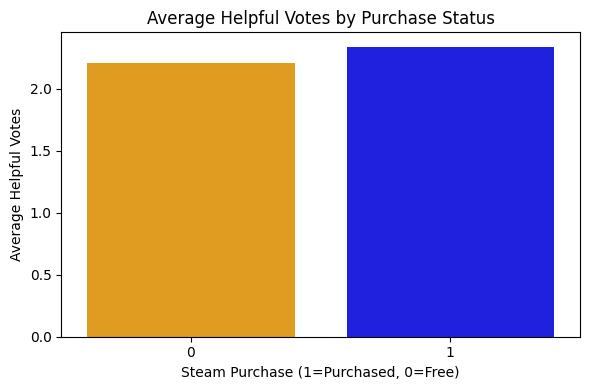

In [53]:
def plot_purchase_helpfulness_bar(df):
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x='steam_purchase', y='avg_helpful_votes', palette=['orange','blue'])
    plt.title("Average Helpful Votes by Purchase Status")
    plt.xlabel("Steam Purchase (1=Purchased, 0=Free)")
    plt.ylabel("Average Helpful Votes")
    plt.tight_layout()
    plt.show()

plot_purchase_helpfulness_bar(df_h1)


In [48]:
def get_purchase_playtime_buckets():
    query = f"""
    SELECT
        CASE 
            WHEN author_playtime_at_review < 5 THEN '0-5h'
            WHEN author_playtime_at_review < 20 THEN '5-20h'
            ELSE '20h+'
        END AS playtime_bucket,
        steam_purchase,
        AVG(votes_up) AS avg_helpful,
        COUNT(*) AS review_count
    FROM {out}
    WHERE votes_up IS NOT NULL
    GROUP BY 1, 2
    ORDER BY 1, 2
    """
    return con.execute(query).fetchdf()

df_buckets = get_purchase_playtime_buckets()
print(df_buckets)


  playtime_bucket  steam_purchase  avg_helpful  review_count
0            0-5h               0     5.627407        493211
1            0-5h               1     7.418657       1363950
2            20h+               0     2.078423      35474839
3            20h+               1     2.175326      70921445
4           5-20h               0     3.794901       1751523
5           5-20h               1     5.695041       1373483


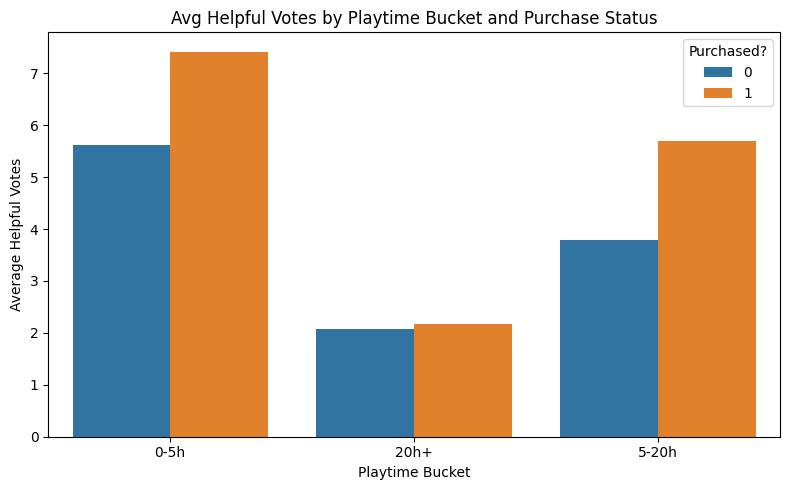

In [49]:

def plot_purchase_playtime_buckets(df):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='playtime_bucket', y='avg_helpful', hue='steam_purchase')
    plt.title("Avg Helpful Votes by Playtime Bucket and Purchase Status")
    plt.xlabel("Playtime Bucket")
    plt.ylabel("Average Helpful Votes")
    plt.legend(title="Purchased?")
    plt.tight_layout()
    plt.show()

plot_purchase_playtime_buckets(df_buckets)


In [51]:
from scipy.stats import ttest_ind

def test_purchase_helpfulness():
    query = f"""
    SELECT
        steam_purchase,
        votes_up
    FROM {out}
    WHERE votes_up IS NOT NULL
    """
    df = con.execute(query).fetchdf()
    purchased = df[df['steam_purchase'] == 1]['votes_up']
    free = df[df['steam_purchase'] == 0]['votes_up']

    t_stat, p_val = ttest_ind(purchased, free, equal_var=False)
    print("T-test for steam_purchase vs. votes_up:")
    print("T-stat:", t_stat)
    print("P-value:", p_val)

test_purchase_helpfulness()


T-test for steam_purchase vs. votes_up:
T-stat: 17.91905173892688
P-value: 8.377267628030137e-72


In [57]:
def get_small_games_list(n=10):
    """
    Returns a list of 'n' game names/IDs that have the fewest total reviews.
    Adjust 'n' as desired.
    """
    query = f"""
    WITH review_counts AS (
        SELECT
            game,
            COUNT(*) AS total_reviews
        FROM {out}
        GROUP BY game
        ORDER BY total_reviews ASC
        LIMIT {n}
    )
    SELECT game
    FROM review_counts;
    """
    rows = con.execute(query).fetchall()
    # Flatten list of tuples to a Python list
    return [r[0] for r in rows]

small_games = get_small_games_list(n=10)
print("Small Games:", small_games)


Small Games: ['Rocksmith 2014 - The Killers - Mr. Brightside', '[Revival] DOA6 Hot Summer Costume - Tina', 'Omega Labyrinth Life - Character Song: Pai', 'Rocksmith 2014 - Mastodon Song Pack', 'Rocksmith 2014 - Deftones - Be Quiet and Drive (Far Away)', 'Purple Saturn Day', 'Story of a Gladiator - Soundtrack', 'Omega Labyrinth Life - Costume: Yurika (Animal)', 'Artifact Adventure Gaiden DX Soundtrack', 'Rocksmith 2014 - Cake - The Distance']


In [58]:
def get_small_games_helpfulness(small_games):
    """
    Returns the average helpful votes grouped by purchase status,
    but only for a specified list of small games.
    """
    # Convert the list of games into a string for SQL IN clause
    games_str = "', '".join(str(g) for g in small_games)
    
    query = f"""
    SELECT
        game,
        steam_purchase,
        AVG(votes_up) AS avg_helpful_votes,
        COUNT(*) AS total_reviews
    FROM {out}
    WHERE votes_up IS NOT NULL
      AND game IN ('{games_str}')
    GROUP BY game, steam_purchase
    ORDER BY game, steam_purchase
    """
    return con.execute(query).fetchdf()

df_small_helpful = get_small_games_helpfulness(small_games)
df_small_helpful.head(10)


,game,steam_purchase,avg_helpful_votes,total_reviews
0,Artifact Adventure Gaiden DX Soundtrack,1,0.0,1
1,Omega Labyrinth Life - Character Song: Pai,1,1.0,1
2,Omega Labyrinth Life - Costume: Yurika (Animal),1,1.0,1
3,Purple Saturn Day,1,4.0,1
4,Rocksmith 2014 - Cake - The Distance,1,4.0,1
5,Rocksmith 2014 - Deftones - Be Quiet and Drive...,1,2.0,1
6,Rocksmith 2014 - Mastodon Song Pack,1,25.0,1
7,Rocksmith 2014 - The Killers - Mr. Brightside,1,27.0,1
8,Story of a Gladiator - Soundtrack,0,0.0,1
9,[Revival] DOA6 Hot Summer Costume - Tina,1,1.0,1


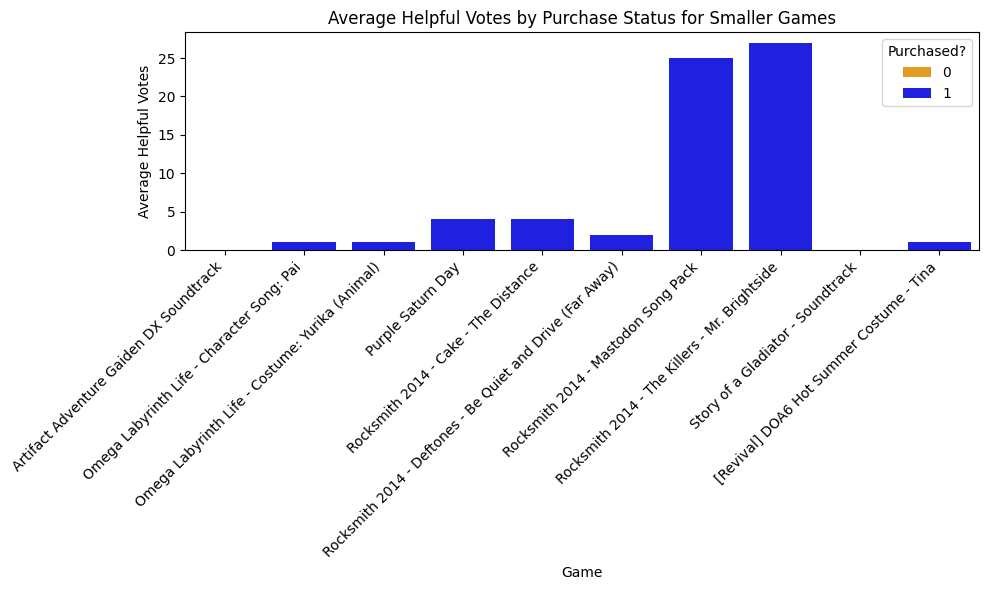

In [59]:


def plot_small_games_helpfulness(df):
    """
    Creates a grouped bar chart of average helpful votes for each small game,
    split by purchase status.
    """
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=df,
        x='game', y='avg_helpful_votes',
        hue='steam_purchase',
        palette=['orange','blue']
    )
    plt.title("Average Helpful Votes by Purchase Status for Smaller Games")
    plt.xlabel("Game")
    plt.ylabel("Average Helpful Votes")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Purchased?")
    plt.tight_layout()
    plt.show()

plot_small_games_helpfulness(df_small_helpful)


In [60]:


def test_small_games_purchase_helpfulness(small_games):
    """
    Performs an independent t-test for each small game,
    comparing purchased vs. free reviews in terms of votes_up.
    """
    results = []
    for g in small_games:
        query = f"""
        SELECT steam_purchase, votes_up
        FROM {out}
        WHERE votes_up IS NOT NULL
          AND game = '{g}'
        """
        df = con.execute(query).fetchdf()
        purchased = df[df['steam_purchase'] == 1]['votes_up']
        free = df[df['steam_purchase'] == 0]['votes_up']
        
        if len(purchased) > 1 and len(free) > 1:
            t_stat, p_val = ttest_ind(purchased, free, equal_var=False)
            results.append((g, t_stat, p_val, len(purchased), len(free)))
        else:
            results.append((g, None, None, len(purchased), len(free)))
    return results

t_results = test_small_games_purchase_helpfulness(small_games)
for row in t_results:
    print(f"Game: {row[0]}, T-stat: {row[1]}, P-value: {row[2]}, Purchased N={row[3]}, Free N={row[4]}")


Game: Rocksmith 2014 - The Killers - Mr. Brightside, T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: [Revival] DOA6 Hot Summer Costume - Tina, T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Omega Labyrinth Life - Character Song: Pai, T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Rocksmith 2014 - Mastodon Song Pack, T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Rocksmith 2014 - Deftones - Be Quiet and Drive (Far Away), T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Purple Saturn Day, T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Story of a Gladiator - Soundtrack, T-stat: None, P-value: None, Purchased N=0, Free N=1
Game: Omega Labyrinth Life - Costume: Yurika (Animal), T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Artifact Adventure Gaiden DX Soundtrack, T-stat: None, P-value: None, Purchased N=1, Free N=0
Game: Rocksmith 2014 - Cake - The Distance, T-stat: None, P-value: None, Purchased N=1, Free N=0

In [61]:
def get_review_counts():
    query = f"""
    SELECT
        game,
        COUNT(*) AS total_reviews
    FROM {out}
    GROUP BY game
    ORDER BY total_reviews DESC
    """
    return con.execute(query).fetchdf()

df_counts = get_review_counts()
df_counts.head()


,game,total_reviews
0,Counter-Strike 2,7704653
1,PUBG: BATTLEGROUNDS,2235431
2,Grand Theft Auto V,1659268
3,Terraria,1205564
4,Garry's Mod,1006609


In [62]:
import numpy as np

def get_top_10pct_cutoff():
    df_counts = get_review_counts()
    # The 'total_reviews' column is sorted descending, but we just need the values
    review_counts = df_counts['total_reviews'].values
    # Calculate the 90th percentile
    cutoff = np.percentile(review_counts, 90)
    return cutoff

cutoff_value = get_top_10pct_cutoff()
print("90th Percentile (Super Popular) Cutoff =", cutoff_value)


90th Percentile (Super Popular) Cutoff = 461.0


In [64]:
def get_less_popular_games():
    cutoff_value = get_top_10pct_cutoff()
    query = f"""
    WITH game_review_counts AS (
        SELECT
            game,
            COUNT(*) AS total_reviews
        FROM {out}
        GROUP BY game
    )
    SELECT game
    FROM game_review_counts
    WHERE total_reviews < {cutoff_value}
    """
    rows = con.execute(query).fetchall()
    return [r[0] for r in rows]

less_popular_games = get_less_popular_games()
print("Number of less popular games:", len(less_popular_games))


Number of less popular games: 92250


In [76]:
def get_monthly_helpful_trend():
    query = f"""
    SELECT
        DATE_TRUNC('month', timestamp_created) AS review_month,
        steam_purchase,
        AVG(votes_up) AS avg_votes_up,
        COUNT(*) AS total_reviews
    FROM {out}
    WHERE votes_up IS NOT NULL
    GROUP BY 1, 2
    ORDER BY review_month, steam_purchase
    """
    return con.execute(query).fetchdf()

df_monthly = get_monthly_helpful_trend()
print(df_monthly.head(10))  # Inspect the first few rows


  review_month  steam_purchase  avg_votes_up  total_reviews
0   2010-10-01               0      1.375000            208
1   2010-10-01               1      0.738667            375
2   2010-11-01               0      0.573066           3141
3   2010-11-01               1      0.624107           5459
4   2010-12-01               0      0.483638           5531
5   2010-12-01               1      0.652569          10333
6   2011-01-01               0      0.583397           2626
7   2011-01-01               1      0.600044           4523
8   2011-02-01               0      0.453813           1862
9   2011-02-01               1      0.640192           2921


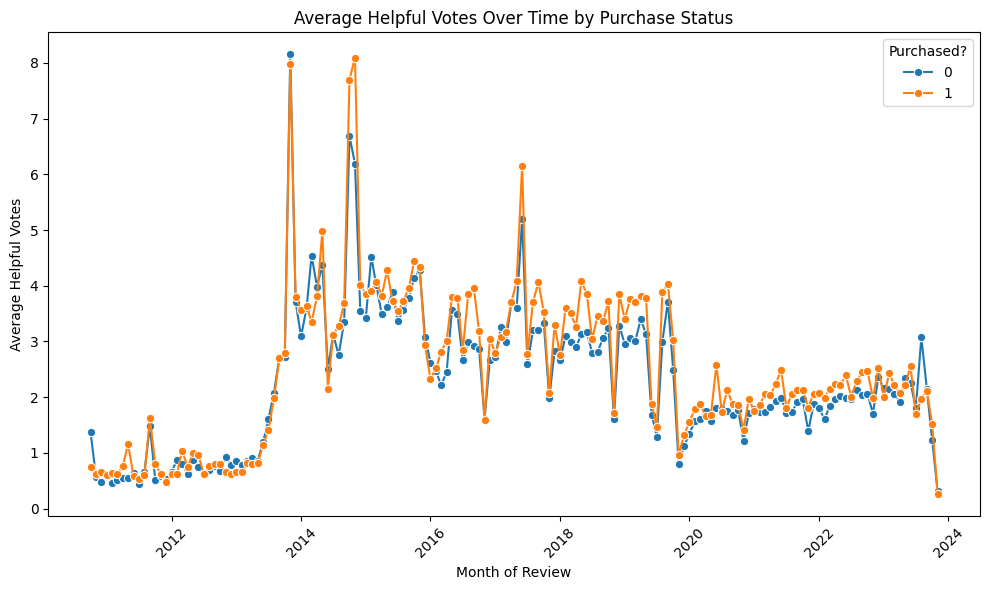

In [77]:

def plot_monthly_helpful_trend(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=df,
        x='review_month', y='avg_votes_up',
        hue='steam_purchase',  # separate lines for purchased vs free
        marker='o'
    )
    plt.title("Average Helpful Votes Over Time by Purchase Status")
    plt.xlabel("Month of Review")
    plt.ylabel("Average Helpful Votes")
    plt.xticks(rotation=45)
    plt.legend(title="Purchased?")
    plt.tight_layout()
    plt.show()

plot_monthly_helpful_trend(df_monthly)


In [5]:
def get_votes_vs_comments():
    query = f"""
    SELECT
        steam_purchase,
        votes_up,
        comment_count
    FROM {out}
    WHERE votes_up IS NOT NULL
      AND comment_count IS NOT NULL
    """
    return con.execute(query).fetchdf()

df_scatter = get_votes_vs_comments()
print(df_scatter.head())


NameError: name 'out' is not defined

In [1]:
def plot_votes_vs_comments_hex(df):
    """
    Creates a 2D hexbin plot of comment_count vs. votes_up,
    ignoring steam_purchase for the moment (or you can split it).
    """
    plt.figure(figsize=(8,6))
    plt.hexbin(
        x=df['comment_count'],
        y=df['votes_up'],
        gridsize=50,   # adjust for resolution
        cmap='viridis',
        bins='log'     # optional log-scaling for bin counts
    )
    plt.title("Helpful Votes vs. Comment Count (Hexbin)")
    plt.xlabel("Comment Count")
    plt.ylabel("Helpful Votes (votes_up)")
    plt.yscale('log')  # optional
    plt.xscale('log')  # optional
    plt.colorbar(label='log10(# of points)')  # if bins='log'
    plt.tight_layout()
    plt.show()


In [2]:


plot_votes_vs_comments_hex(df_scatter)


NameError: name 'df_scatter' is not defined